# PROJET DE SOUTENANCE - DATAGONG x 10.000 Codeurs

## 0. PRESENTATION

Sujet : Prédiction du parti politique victorieux des élection présidentielles de 2020 aux USA à partir de données socio-démographiques

Plan de travail :

- Setup (Installation et import des librairies nécessaires)
- Import des données
- Préparation & Constitution de la donnée exploitable
- Analyse exploratoire
- Modélisation
- Evaluation
- Conclusion

## 1. Setup

### 1.1. INSTALLATION DES DEPENDANCES

Nous devons installer les librairies suivantes :

- pandas
- numpy
- scikit-learn
- xlrd
- openpyxl
- matplotlib
- seaborn
- shap
- xgboost

Pour cela, nous pouvons utiliser la commande suivante :

```bash
pip install -r requirements.txt
```

In [2]:
# Commande pour installer les dépendances
!pip install -r requirements.txt

### 1.2. IMPORTATION DES LIBRAIRIES

In [1]:
# Importation des bibliothèques principales
  
import numpy as np  # Manipulation de tableaux numériques, gestion des calculs mathématiques  
import pandas as pd  # Gestion et manipulation des données sous forme de DataFrame  

# Visualisation des données  
import seaborn as sns  # Création de graphiques statistiques avancés  
import matplotlib.pyplot as plt  # Génération de visualisations basiques (histogrammes, scatter plots, etc.)  

# Préparation des données et séparation en train/test  
from sklearn.model_selection import train_test_split  # Découpage des données en ensembles d'entraînement et de test  
from sklearn.preprocessing import OneHotEncoder  # Encodage des variables catégorielles en variables numériques  

# Modèle de base (Régression Logistique)  
from sklearn.linear_model import LogisticRegression  # Modèle de régression logistique pour la classification  

# Évaluation des modèles  
from sklearn.metrics import classification_report  # Génération d’un rapport de performance des modèles  

# Gestion des classes déséquilibrées  
from sklearn.utils import resample  # Sous-échantillonnage de la classe majoritaire (undersampling)  
from imblearn.over_sampling import SMOTE  # Sur-échantillonnage de la classe minoritaire (oversampling)  

# Modèles avancés  
from sklearn.ensemble import RandomForestClassifier  # Modèle de Random Forest pour la classification  
from xgboost import XGBClassifier  # Modèle XGBoost pour une classification optimisée  

# Optimisation des modèles  
from sklearn.model_selection import GridSearchCV  # Recherche des meilleurs hyperparamètres avec validation croisée  
from imblearn.pipeline import Pipeline as ImbPipeline  # Création d'un pipeline intégrant le prétraitement et le modèle  

# Interprétabilité des modèles  
import shap  # Explication des prédictions des modèles avec SHAP (SHapley Additive exPlanations)  

# Profilage
from tqdm import tqdm  # Affichage de barres de progression pour suivre l’exécution des boucles


/home/raouf/workspaces/personal/courses/datagong/mvenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. IMPORTATION DES DONNÉES

In [3]:
# Résultats des élections présidentielles de 2020 au niveau des comtés
elections_2020 = pd.read_csv('./data/2020_US_County_Level_Presidential_Results.csv')

# Résultats des élections présidentielles de 2008 à 2016 au niveau des comtés
# Ce fichier ne sera utilisé que pour l’analyse exploratoire (comparaison des tendances)
elections_08_16 = pd.read_csv('./data/US_County_Level_Presidential_Results_08-16.csv')

# Données démographiques : Estimations de la population par comté
population = pd.read_excel('./data/PopulationEstimates.xls', engine='xlrd', header=2)

# Données sur l’éducation : niveaux d’études atteints par comté
education = pd.read_excel('./data/Education.xls', engine='xlrd', header=4)

# Données sur la pauvreté : taux de pauvreté par comté
poverty = pd.read_excel('./data/PovertyEstimates.xls', engine='xlrd', header=4)

# Données sur le chômage : taux de chômage par comté
unemployment = pd.read_excel('./data/Unemployment.xls', engine='xlrd', header=4)


## 3. PREPARATION ET CONSTITUTION DES DONNEES

### 3.1. Etape 1

In [4]:
# Harmonisation des colonnes pour assurer une cohérence entre les datasets

# Sélection et renommage des colonnes pour les résultats des élections 2020
df_2020 = elections_2020[['county_fips', 'county_name', 'state_name']].rename(
    columns={'county_fips': 'fips', 'county_name': 'county_name', 'state_name': 'state_name'}
)

# Sélection et renommage des colonnes pour les résultats des élections 2008-2016
df_08_16 = elections_08_16[['fips_code', 'county']].rename(
    columns={'fips_code': 'fips', 'county': 'county_name'}
)

# Sélection et renommage des colonnes pour les données de population
df_population = population[['FIPStxt', 'Area_Name', 'State']].rename(
    columns={'FIPStxt': 'fips', 'Area_Name': 'county_name', 'State': 'state_code'}
)

# Sélection et renommage des colonnes pour les données d'éducation
df_education = education[['FIPS Code', 'Area name', 'State']].rename(
    columns={'FIPS Code': 'fips', 'Area name': 'county_name', 'State': 'state_code'}
)

# Sélection et renommage des colonnes pour les données de pauvreté
df_poverty = poverty[['FIPStxt', 'Area_name', 'Stabr']].rename(
    columns={'FIPStxt': 'fips', 'Area_name': 'county_name', 'Stabr': 'state_code'}
)

# Sélection et renommage des colonnes pour les données de chômage
df_unemployment = unemployment[['fips_txt', 'area_name', 'Stabr']].rename(
    columns={'fips_txt': 'fips', 'area_name': 'county_name', 'Stabr': 'state_code'}
)


# Concaténation de tous les jeux de données en un seul DataFrame
checkpoint_0_raw = pd.concat([
    df_2020,
    df_08_16,
    df_population,
    df_education,
    df_poverty,
    df_unemployment
], ignore_index=True)

In [5]:
checkpoint_0_raw

,fips,county_name,state_name,state_code
0,1001,Autauga County,Alabama,NaN
1,1003,Baldwin County,Alabama,NaN
2,1005,Barbour County,Alabama,NaN
3,1007,Bibb County,Alabama,NaN
4,1009,Blount County,Alabama,NaN
...,...,...,...,...
19283,72145,"Vega Baja Municipio, PR",NaN,PR
19284,72147,"Vieques Municipio, PR",NaN,PR
19285,72149,"Villalba Municipio, PR",NaN,PR
19286,72151,"Yabucoa Municipio, PR",NaN,PR


In [6]:
# Harmonisation du code FIPS sur 5 caractères (ajout de zéros devant si nécessaire)
checkpoint_0_raw['fips'] = checkpoint_0_raw['fips'].astype(str).str.zfill(5)
checkpoint_0_raw

,fips,county_name,state_name,state_code
0,01001,Autauga County,Alabama,NaN
1,01003,Baldwin County,Alabama,NaN
2,01005,Barbour County,Alabama,NaN
3,01007,Bibb County,Alabama,NaN
4,01009,Blount County,Alabama,NaN
...,...,...,...,...
19283,72145,"Vega Baja Municipio, PR",NaN,PR
19284,72147,"Vieques Municipio, PR",NaN,PR
19285,72149,"Villalba Municipio, PR",NaN,PR
19286,72151,"Yabucoa Municipio, PR",NaN,PR


In [7]:
# Suppression des doublons basés sur le FIPS (identifiant unique des comtés)
checkpoint_0 = checkpoint_0_raw.drop_duplicates(subset=['fips']).sort_values(by='fips').reset_index(drop=True)

In [8]:
# Vérification des premières lignes du DataFrame final
checkpoint_0

,fips,county_name,state_name,state_code
0,00000,United States,NaN,US
1,01000,Alabama,NaN,AL
2,01001,Autauga County,Alabama,NaN
3,01003,Baldwin County,Alabama,NaN
4,01005,Barbour County,Alabama,NaN
...,...,...,...,...
3319,72145,"Vega Baja Municipio, Puerto Rico",NaN,PR
3320,72147,"Vieques Municipio, Puerto Rico",NaN,PR
3321,72149,"Villalba Municipio, Puerto Rico",NaN,PR
3322,72151,"Yabucoa Municipio, Puerto Rico",NaN,PR


In [9]:
# Sauvegarde du DataFrame harmonisé dans un fichier Excel
checkpoint_0.to_excel('checkpoints/save_0.xlsx', index=False)
print("\n✅ Données harmonisées sauvegardées dans 'checkpoints/save_0.xlsx'.")


✅ Données harmonisées sauvegardées dans 'checkpoints/save_0.xlsx'.


### 3.2. Etape 2

In [10]:
# Chargement du fichier harmonisé précédent
ch0 = pd.read_excel('checkpoints/save_0.xlsx')  

# Liste des sources utilisées pour compléter les valeurs manquantes
sources = [df_2020, df_08_16, df_population, df_education, df_poverty, df_unemployment]

# Liste des colonnes à compléter si elles sont absentes
columns_to_fill = ['county_name', 'state_code', 'state_name']

# Vérification et création des colonnes manquantes si elles ne sont pas présentes dans `dm0`
for col in columns_to_fill:
    if col not in ch0.columns:
        ch0[col] = pd.NA  # Remplissage initial avec des valeurs manquantes

# Fonction pour compléter les valeurs manquantes en se basant sur les autres sources
def fill_missing_values(base_df, sources, columns_to_fill):
    """
    Remplit les valeurs manquantes d'un DataFrame en utilisant d'autres sources de données.
    
    - base_df : DataFrame principal contenant des valeurs manquantes
    - sources : Liste des DataFrames sources
    - columns_to_fill : Liste des colonnes à compléter
    """
    for source in sources:
        for col in columns_to_fill:
            if col in source.columns:  # Vérifie si la colonne existe dans la source
                base_df[col] = base_df[col].fillna(
                    base_df['fips'].map(source.set_index('fips')[col])  # Remplissage basé sur la correspondance FIPS
                )
    return base_df


In [11]:
# Application de la fonction pour compléter les valeurs manquantes
checkpoint_1_raw = fill_missing_values(ch0, sources, columns_to_fill)

# Vérification des valeurs manquantes après remplissage
ch1_missing_data = checkpoint_1_raw[columns_to_fill].isnull().sum()
print(f"Valeurs manquantes après remplissage :\n{ch1_missing_data}")

Valeurs manquantes après remplissage :
county_name      0
state_code      41
state_name     172
dtype: int64


In [12]:
# Sauvegarde du fichier complété
checkpoint_1_raw.to_excel('checkpoints/save_1.xlsx', index=False)
print("\n✅ Données complétées sauvegardées dans 'checkpoints/save_1.xlsx'.")


✅ Données complétées sauvegardées dans 'checkpoints/save_1.xlsx'.


### 3.3. Etape 3

In [13]:
df_2020 = elections_2020[['county_fips', 'county_name', 'state_name']].rename(
    columns={'county_fips': 'county_code', 'county_name': 'county_name', 'state_name': 'state_name'})

df_08_16 = elections_08_16[['fips_code', 'county']].rename(
    columns={'fips_code': 'county_code', 'county': 'county_name'})

df_population = population[['FIPStxt', 'Area_Name', 'State']].rename(
    columns={'FIPStxt': 'county_code', 'Area_Name': 'county_name', 'State': 'state_code'})

df_education = education[['FIPS Code', 'Area name', 'State']].rename(
    columns={'FIPS Code': 'county_code', 'Area name': 'county_name', 'State': 'state_code'})

df_poverty = poverty[['FIPStxt', 'Area_name', 'Stabr']].rename(
    columns={'FIPStxt': 'county_code', 'Area_name': 'county_name', 'Stabr': 'state_code'})

df_unemployment = unemployment[['fips_txt', 'area_name', 'Stabr']].rename(
    columns={'fips_txt': 'county_code', 'area_name': 'county_name', 'Stabr': 'state_code'})

# Liste des sources et leur priorité
sources = [df_2020, df_08_16, df_population, df_education, df_poverty, df_unemployment]

# Charger le fichier harmonisé existant ou créer une base vide
ch1 = pd.read_excel('checkpoints/save_1.xlsx')

# Renommer la colonne principale en `county_code`
ch1.rename(columns={'fips': 'county_code'}, inplace=True)

# S'assurer que `county_code` est formaté sur 5 chiffres
ch1['county_code'] = ch1['county_code'].astype(str).str.zfill(5)

# Ajouter les colonnes manquantes
columns_to_fill = ['county_name', 'state_code', 'state_name']
for col in columns_to_fill:
    if col not in ch1.columns:
        ch1[col] = pd.NA

# Fonction pour combler les valeurs manquantes
def fill_missing_values(base_df, sources, columns_to_fill):
    for source in sources:
        # S'assurer que county_code est au bon format dans les sources
        source['county_code'] = source['county_code'].astype(str).str.zfill(5)
        for col in columns_to_fill:
            if col in source.columns:  # Vérifier que la colonne existe dans la source
                base_df[col] = base_df[col].fillna(
                    base_df['county_code'].map(source.set_index('county_code')[col])  # Remplir selon la clé county_code
                )
    return base_df

In [14]:
# Compléter les colonnes manquantes
checkpoint_2_raw = fill_missing_values(ch1, sources, columns_to_fill)

# Vérification des valeurs manquantes
ch2_missing_data = checkpoint_2_raw[columns_to_fill].isnull().sum()
print(f"Valeurs manquantes après remplissage :\n{ch2_missing_data}")

Valeurs manquantes après remplissage :
county_name      0
state_code      41
state_name     172
dtype: int64


In [15]:
# Sauvegarder les données complètes
checkpoint_2_raw.to_excel('checkpoints/save_2.xlsx', index=False)
print("\nDonnées complétées sauvegardées dans 'checkpoints/save_2.xlsx'.")



Données complétées sauvegardées dans 'checkpoints/save_2.xlsx'.


### 3.4. Etape 4

In [16]:
elections_2020 = elections_2020[['county_fips', 'per_gop', 'per_dem']].rename(columns={'county_fips': 'county_code'})
elections_08_16 = elections_08_16[['fips_code', 'total_2016', 'dem_2016', 'gop_2016']].rename(columns={'fips_code': 'county_code'})
population = population[['FIPStxt', 'Rural-urban_Continuum Code_2013', 'Urban_Influence_Code_2013']].rename(
    columns={'FIPStxt': 'county_code', 'Rural-urban_Continuum Code_2013': 'rural_urban_code',
             'Urban_Influence_Code_2013': 'urban_influence_code'})
education = education[['FIPS Code', 'Percent of adults with less than a high school diploma, 2015-19',
                       'Percent of adults with a high school diploma only, 2015-19',
                       'Percent of adults completing some college or associate\'s degree, 2015-19',
                       'Percent of adults with a bachelor\'s degree or higher, 2015-19']].rename(
    columns={'FIPS Code': 'county_code',
             'Percent of adults with less than a high school diploma, 2015-19': 'percent_no_highschool',
             'Percent of adults with a high school diploma only, 2015-19': 'percent_highschool',
             'Percent of adults completing some college or associate\'s degree, 2015-19': 'percent_college',
             'Percent of adults with a bachelor\'s degree or higher, 2015-19': 'percent_bachelor'})
poverty = poverty[['FIPStxt', 'PCTPOVALL_2019', 'MEDHHINC_2019']].rename(
    columns={'FIPStxt': 'county_code', 'PCTPOVALL_2019': 'percent_poverty',
             'MEDHHINC_2019': 'median_household_income'})
unemployment = unemployment[['fips_txt', 'Unemployment_rate_2019', 'Employed_2019', 'Unemployed_2019']].rename(
    columns={'fips_txt': 'county_code', 'Unemployment_rate_2019': 'unemployment_rate'})

# Standardiser le format des `county_code` (5 caractères)
datasets = [elections_2020, elections_08_16, population, education, poverty, unemployment]
for df in datasets:
    df['county_code'] = df['county_code'].astype(str).str.zfill(5)

datamap = pd.read_excel('checkpoints/save_2.xlsx')
datamap['county_code'] = datamap['county_code'].astype(str).str.zfill(5)


# Liste des colonnes pertinentes à ajouter
columns_to_add = {
    'elections_2020': ['per_gop', 'per_dem'],
    'elections_08_16': ['total_2016', 'dem_2016', 'gop_2016'],
    'population': ['rural_urban_code', 'urban_influence_code'],
    'education': ['percent_no_highschool', 'percent_highschool', 'percent_college', 'percent_bachelor'],
    'poverty': ['percent_poverty', 'median_household_income'],
    'unemployment': ['unemployment_rate', 'Employed_2019', 'Unemployed_2019']
}

# Compléter les colonnes manquantes dans le fichier datamap
for source, cols in zip(datasets, columns_to_add.values()):
    for col in cols:
        if col not in datamap.columns:
            datamap[col] = pd.NA
        datamap[col] = datamap[col].fillna(datamap['county_code'].map(source.set_index('county_code')[col]))
print(datamap)
# Sauvegarder le fichier enrichi
datamap.to_excel('checkpoints/save_3.xlsx', index=False)
print("\nFichier 'checkpoints/save_3.xlsx' sauvegardé avec toutes les données intégrées.")


     county_code                       county_name state_name state_code  \
0          00000                     United States        NaN         US   
1          01000                           Alabama        NaN         AL   
2          01001                    Autauga County    Alabama         AL   
3          01003                    Baldwin County    Alabama         AL   
4          01005                    Barbour County    Alabama         AL   
...          ...                               ...        ...        ...   
3319       72145  Vega Baja Municipio, Puerto Rico        NaN         PR   
3320       72147    Vieques Municipio, Puerto Rico        NaN         PR   
3321       72149   Villalba Municipio, Puerto Rico        NaN         PR   
3322       72151    Yabucoa Municipio, Puerto Rico        NaN         PR   
3323       72153      Yauco Municipio, Puerto Rico        NaN         PR   

       per_gop   per_dem  total_2016  dem_2016  gop_2016  rural_urban_code  \
0        

/tmp/ipykernel_44211/2905226830.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  datamap[col] = datamap[col].fillna(datamap['county_code'].map(source.set_index('county_code')[col]))
/tmp/ipykernel_44211/2905226830.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  datamap[col] = datamap[col].fillna(datamap['county_code'].map(source.set_index('county_code')[col]))
/tmp/ipykernel_44211/2905226830.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_object


Fichier 'checkpoints/save_3.xlsx' sauvegardé avec toutes les données intégrées.


In [17]:
# Vérifier les valeurs manquantes
missing_data = datamap.isnull().sum()
print("Valeurs manquantes par colonne :\n", missing_data)

# Pourcentage de valeurs manquantes
missing_percentage = (missing_data / len(datamap)) * 100
print("\nPourcentage de valeurs manquantes par colonne :\n", missing_percentage)

# Vérifier les doublons
duplicate_count = datamap.duplicated().sum()
print(f"Nombre de doublons dans le DataFrame : {duplicate_count}")

# Statistiques descriptives
stats = datamap.describe()
print("Statistiques descriptives :\n", stats)


Valeurs manquantes par colonne :
 county_code                  0
county_name                  0
state_name                 172
state_code                  41
per_gop                    172
per_dem                    172
total_2016                 212
dem_2016                   212
gop_2016                   212
rural_urban_code           104
urban_influence_code       104
percent_no_highschool       51
percent_highschool          51
percent_college             51
percent_bachelor            51
percent_poverty            131
median_household_income    131
unemployment_rate           52
Employed_2019               52
Unemployed_2019             52
dtype: int64

Pourcentage de valeurs manquantes par colonne :
 county_code                0.000000
county_name                0.000000
state_name                 5.174489
state_code                 1.233454
per_gop                    5.174489
per_dem                    5.174489
total_2016                 6.377858
dem_2016                   6.37

### REMARQUE

Ici on remarque que les données qui manques pour `per_gop`, `per_dem`, `total_2016`, `dem_2016`, `gop_2016`, `rural_urban_code`, `urban_influence_code` les zone regionales.

par exemple Alasca (02000) a ses county 02*** 
            Alabama (01000) a ses county 01***

In [18]:
datamap['is_state'] = datamap['county_code'].apply(lambda x: 1 if x.endswith('000') else 0)
datamap_complete = datamap.copy()
print(datamap_complete.head())

# Sauvegarder le fichier enrichi
datamap.to_excel('checkpoints/save_4.xlsx', index=False)
print("\nFichier 'checkpoints/save_4.xlsx' sauvegardé avec toutes les données intégrées.")

  county_code     county_name state_name state_code   per_gop   per_dem  \
0       00000   United States        NaN         US       NaN       NaN   
1       01000         Alabama        NaN         AL       NaN       NaN   
2       01001  Autauga County    Alabama         AL  0.714368  0.270184   
3       01003  Baldwin County    Alabama         AL  0.761714  0.224090   
4       01005  Barbour County    Alabama         AL  0.534512  0.457882   

   total_2016  dem_2016  gop_2016  rural_urban_code  ...  \
0         NaN       NaN       NaN               NaN  ...   
1         NaN       NaN       NaN               NaN  ...   
2     24661.0    5908.0   18110.0               2.0  ...   
3     94090.0   18409.0   72780.0               3.0  ...   
4     10390.0    4848.0    5431.0               6.0  ...   

   percent_no_highschool  percent_highschool  percent_college  \
0              11.998918           26.956844        28.898697   
1              13.819302           30.800268        29.912

In [19]:
# Filtrer uniquement les comtés (is_state == 0)
datamap_counties = datamap[datamap['is_state'] == 0].copy()

# Vérification
print(f"Nombre total d'observations : {len(datamap)}")
print(f"Nombre de comtés : {len(datamap_counties)}")
print(datamap_counties.head())

# Sauvegarder le fichier enrichi
datamap_counties.to_excel('checkpoints/counties_0.xlsx', index=False)
print("\nFichier 'checkpoints/counties_0.xlsx' sauvegardé avec toutes les données intégrées.")


Nombre total d'observations : 3324
Nombre de comtés : 3271
  county_code     county_name state_name state_code   per_gop   per_dem  \
2       01001  Autauga County    Alabama         AL  0.714368  0.270184   
3       01003  Baldwin County    Alabama         AL  0.761714  0.224090   
4       01005  Barbour County    Alabama         AL  0.534512  0.457882   
5       01007     Bibb County    Alabama         AL  0.784263  0.206983   
6       01009   Blount County    Alabama         AL  0.895716  0.095694   

   total_2016  dem_2016  gop_2016  rural_urban_code  ...  \
2     24661.0    5908.0   18110.0               2.0  ...   
3     94090.0   18409.0   72780.0               3.0  ...   
4     10390.0    4848.0    5431.0               6.0  ...   
5      8748.0    1874.0    6733.0               1.0  ...   
6     25384.0    2150.0   22808.0               1.0  ...   

   percent_no_highschool  percent_highschool  percent_college  \
2              11.483395           33.588459        28.356571   

In [20]:
# Identifier les valeurs manquantes par colonne
missing_data = datamap_counties.isnull().sum()
missing_percentage = (missing_data / len(datamap_counties)) * 100
print("Valeurs manquantes par colonne :\n", missing_data)
print("\nPourcentage de valeurs manquantes par colonne :\n", missing_percentage)

Valeurs manquantes par colonne :
 county_code                  0
county_name                  0
state_name                 119
state_code                  41
per_gop                    119
per_dem                    119
total_2016                 159
dem_2016                   159
gop_2016                   159
rural_urban_code            51
urban_influence_code        51
percent_no_highschool       51
percent_highschool          51
percent_college             51
percent_bachelor            51
percent_poverty            130
median_household_income    130
unemployment_rate           52
Employed_2019               52
Unemployed_2019             52
is_state                     0
dtype: int64

Pourcentage de valeurs manquantes par colonne :
 county_code                0.000000
county_name                0.000000
state_name                 3.638031
state_code                 1.253439
per_gop                    3.638031
per_dem                    3.638031
total_2016                 4.860899


In [21]:
# Identifier les lignes où 'county_name' contient "Puerto Rico"
puerto_rico_rows = datamap_counties['county_name'].str.contains("Puerto Rico", na=False)

# Remplir 'state_name' avec "Puerto Rico"
datamap_counties.loc[puerto_rico_rows, 'state_name'] = "Puerto Rico"

# Nettoyer 'county_name' en retirant "Puerto Rico"
datamap_counties.loc[puerto_rico_rows, 'county_name'] = datamap_counties.loc[puerto_rico_rows, 'county_name'].str.replace(", Puerto Rico", "", regex=False)

# Vérification
print(datamap_counties[puerto_rico_rows].head())

     county_code             county_name   state_name state_code  per_gop  \
3246       72001      Adjuntas Municipio  Puerto Rico         PR      NaN   
3247       72003        Aguada Municipio  Puerto Rico         PR      NaN   
3248       72005     Aguadilla Municipio  Puerto Rico         PR      NaN   
3249       72007  Aguas Buenas Municipio  Puerto Rico         PR      NaN   
3250       72009      Aibonito Municipio  Puerto Rico         PR      NaN   

      per_dem  total_2016  dem_2016  gop_2016  rural_urban_code  ...  \
3246      NaN         NaN       NaN       NaN               6.0  ...   
3247      NaN         NaN       NaN       NaN               2.0  ...   
3248      NaN         NaN       NaN       NaN               2.0  ...   
3249      NaN         NaN       NaN       NaN               1.0  ...   
3250      NaN         NaN       NaN       NaN               1.0  ...   

      percent_no_highschool  percent_highschool  percent_college  \
3246              34.680054         

In [22]:
# Dictionnaire associant les state_code aux state_name
state_mapping = {
    "AK": "Alaska",
}

# Corriger 'state_name' en utilisant 'state_code'
datamap_counties['state_name'] = datamap_counties.apply(
    lambda row: state_mapping[row['state_code']] if pd.notnull(row['state_code']) and row['state_code'] in state_mapping else row['state_name'], axis=1
)

# Corriger 'state_code' en utilisant 'state_name'
datamap_counties['state_code'] = datamap_counties.apply(
    lambda row: {v: k for k, v in state_mapping.items()}.get(row['state_name'], row['state_code']), axis=1
)

# Vérification
print(datamap_counties[['state_code', 'state_name']].drop_duplicates().head())


    state_code  state_name
2           AL     Alabama
70          AK      Alaska
147         AZ     Arizona
163         AR    Arkansas
239         CA  California


In [23]:
# Sauvegarder le fichier enrichi
datamap_counties.to_excel('checkpoints/counties_1.xlsx', index=False)
print("\nFichier 'checkpoints/counties_1.xlsx' sauvegardé avec toutes les données intégrées.")


Fichier 'checkpoints/counties_1.xlsx' sauvegardé avec toutes les données intégrées.


In [24]:
# Charger le fichier nettoyé pour analyse
file_path = "checkpoints/counties_1.xlsx"
data = pd.read_excel(file_path)

# Identifier les valeurs manquantes par colonne
missing_data = data.isnull().sum()
missing_percentage = (missing_data / len(data)) * 100

# Préparer un DataFrame pour visualiser les colonnes avec valeurs manquantes
missing_summary = pd.DataFrame({
    "Colonne": missing_data.index,
    "Valeurs Manquantes": missing_data.values,
    "Pourcentage (%)": missing_percentage.values
})

# Filtrer uniquement les colonnes avec des valeurs manquantes
missing_summary = missing_summary[missing_summary["Valeurs Manquantes"] > 0]
print(missing_summary)

                    Colonne  Valeurs Manquantes  Pourcentage (%)
2                state_name                   5         0.152858
3                state_code                   1         0.030572
4                   per_gop                 119         3.638031
5                   per_dem                 119         3.638031
6                total_2016                 159         4.860899
7                  dem_2016                 159         4.860899
8                  gop_2016                 159         4.860899
9          rural_urban_code                  51         1.559156
10     urban_influence_code                  51         1.559156
11    percent_no_highschool                  51         1.559156
12       percent_highschool                  51         1.559156
13          percent_college                  51         1.559156
14         percent_bachelor                  51         1.559156
15          percent_poverty                 130         3.974320
16  median_household_inco

In [25]:
# Colonnes socio-démographiques à imputer
columns_to_fill_mean = ['percent_poverty', 'median_household_income', 'unemployment_rate',
                        'percent_no_highschool', 'percent_highschool', 'percent_college', 'percent_bachelor']

# Remplir les valeurs manquantes par la moyenne
for col in columns_to_fill_mean:
    data[col].fillna(data[col].mean(), inplace=True)

# Vérification après imputation
missing_data_after = data.isnull().sum()
print("Valeurs manquantes après imputation :\n", missing_data_after)


Valeurs manquantes après imputation :
 county_code                  0
county_name                  0
state_name                   5
state_code                   1
per_gop                    119
per_dem                    119
total_2016                 159
dem_2016                   159
gop_2016                   159
rural_urban_code            51
urban_influence_code        51
percent_no_highschool        0
percent_highschool           0
percent_college              0
percent_bachelor             0
percent_poverty              0
median_household_income      0
unemployment_rate            0
Employed_2019               52
Unemployed_2019             52
is_state                     0
dtype: int64


/tmp/ipykernel_44211/895207558.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)


In [26]:
# Colonnes à exclure
#columns_to_exclude = ['per_gop', 'per_dem', 'total_2016', 'dem_2016', 'gop_2016']
columns_to_exclude = ['total_2016', 'dem_2016', 'gop_2016']

# Créer un DataFrame spécifique à la modélisation
data_for_model = data.drop(columns=columns_to_exclude)

# Vérification des dimensions
print(f"Dimensions du DataFrame original : {data.shape}")
print(f"Dimensions du DataFrame pour la modélisation : {data_for_model.shape}")

# Sauvegarder le fichier enrichi
data_for_model.to_excel('checkpoints/dataframe_draft1.xlsx', index=False)
print("\nFichier 'checkpoints/dataframe_draft1.xlsx' sauvegardé avec toutes les données intégrées.")


Dimensions du DataFrame original : (3271, 21)
Dimensions du DataFrame pour la modélisation : (3271, 18)

Fichier 'checkpoints/dataframe_draft1.xlsx' sauvegardé avec toutes les données intégrées.


In [27]:
# Identifier les lignes où state_name ou state_code est manquant
missing_states = data_for_model[data_for_model['state_name'].isnull() | data_for_model['state_code'].isnull()]

# Afficher les lignes avec des valeurs manquantes
print("Lignes avec des valeurs manquantes pour state_name ou state_code :")
print(missing_states[['state_name', 'state_code', 'county_name']])


Lignes avec des valeurs manquantes pour state_name ou state_code :
     state_name state_code                county_name
595         NaN         HI             Kalawao County
1701        NaN         MT  Yellowstone National Park
2466        NaN        NaN             Shannon County
2965        NaN         VA               Bedford city
2970        NaN         VA         Clifton Forge city


In [28]:
missing_data = data_for_model.isnull().sum()
missing_percentage = (missing_data / len(data_for_model)) * 100

# Résumer les colonnes avec des valeurs manquantes
missing_summary = pd.DataFrame({
    "Colonne": missing_data.index,
    "Valeurs Manquantes": missing_data.values,
    "Pourcentage (%)": missing_percentage.values
})
missing_summary = missing_summary[missing_summary["Valeurs Manquantes"] > 0]

print("Résumé des valeurs manquantes :")
print(missing_summary)

Résumé des valeurs manquantes :
                 Colonne  Valeurs Manquantes  Pourcentage (%)
2             state_name                   5         0.152858
3             state_code                   1         0.030572
4                per_gop                 119         3.638031
5                per_dem                 119         3.638031
6       rural_urban_code                  51         1.559156
7   urban_influence_code                  51         1.559156
15         Employed_2019                  52         1.589728
16       Unemployed_2019                  52         1.589728


In [29]:
# Extraire les états (is_state == 1) et corriger les colonnes
states_data = datamap_complete[datamap_complete['is_state'] == 1][['county_code', 'county_name', 'state_code']]

# Renommer county_name en state_name pour les états
states_data.rename(columns={'county_name': 'state_name'}, inplace=True)

# Créer un dictionnaire reliant le préfixe de county_code (state code) aux informations d'état
state_info = states_data.set_index('county_code').to_dict(orient='index')

# Vérification
print("Dictionnaire des états :")
print(state_info)

# Fonction pour retrouver le state_name et state_code à partir du county_code
def fill_state_info(row):
    if pd.isnull(row['state_name']) or pd.isnull(row['state_code']):
        # Obtenir le préfixe de l'état à partir du county_code
        state_prefix = str(row['county_code'])[:2] + "000"
        # Récupérer les informations de l'état
        state_data = state_info.get(state_prefix, {})
        # Compléter les valeurs manquantes
        row['state_name'] = state_data.get('state_name', row['state_name'])
        row['state_code'] = state_data.get('state_code', row['state_code'])
    return row

# Appliquer la fonction sur tout le DataFrame
data_for_model = data_for_model.apply(fill_state_info, axis=1)

Dictionnaire des états :
{'00000': {'state_name': 'United States', 'state_code': 'US'}, '01000': {'state_name': 'Alabama', 'state_code': 'AL'}, '02000': {'state_name': 'Alaska', 'state_code': 'AK'}, '04000': {'state_name': 'Arizona', 'state_code': 'AZ'}, '05000': {'state_name': 'Arkansas', 'state_code': 'AR'}, '06000': {'state_name': 'California', 'state_code': 'CA'}, '08000': {'state_name': 'Colorado', 'state_code': 'CO'}, '09000': {'state_name': 'Connecticut', 'state_code': 'CT'}, '10000': {'state_name': 'Delaware', 'state_code': 'DE'}, '11000': {'state_name': 'District of Columbia', 'state_code': 'DC'}, '12000': {'state_name': 'Florida', 'state_code': 'FL'}, '13000': {'state_name': 'Georgia', 'state_code': 'GA'}, '15000': {'state_name': 'Hawaii', 'state_code': 'HI'}, '16000': {'state_name': 'Idaho', 'state_code': 'ID'}, '17000': {'state_name': 'Illinois', 'state_code': 'IL'}, '18000': {'state_name': 'Indiana', 'state_code': 'IN'}, '19000': {'state_name': 'Iowa', 'state_code': 'IA'},

In [30]:
# Vérifier les valeurs manquantes après correction
missing_states_final = data_for_model[data_for_model['state_name'].isnull() | data_for_model['state_code'].isnull()]
print("Lignes restantes avec des valeurs manquantes pour state_name ou state_code :")
print(missing_states_final[['county_code', 'state_name', 'state_code', 'county_name']])

# Profiter et ajouter le lead 0 au code de département
data_for_model['county_code'] = data_for_model['county_code'].astype(str).str.zfill(5)


# Sauvegarder le fichier corrigé
data_for_model.to_excel("checkpoints/dataframe_draft2.xlsx", index=False)
print("Le fichier corrigé a été sauvegardé sous 'checkpoints/dataframe_draft2.xlsx'.")

Lignes restantes avec des valeurs manquantes pour state_name ou state_code :
Empty DataFrame
Columns: [county_code, state_name, state_code, county_name]
Index: []
Le fichier corrigé a été sauvegardé sous 'checkpoints/dataframe_draft2.xlsx'.


In [31]:
# Vérifier les valeurs manquantes
missing_summary = data_for_model.isnull().sum()
print("Valeurs manquantes :\n", missing_summary[missing_summary > 0])

# Vérifier les doublons
duplicate_count = data_for_model.duplicated().sum()
print(f"Nombre de doublons : {duplicate_count}")

# Vérifier les types de colonnes
print("Types de colonnes :\n", data_for_model.dtypes)

Valeurs manquantes :
 per_gop                 119
per_dem                 119
rural_urban_code         51
urban_influence_code     51
Employed_2019            52
Unemployed_2019          52
dtype: int64
Nombre de doublons : 0
Types de colonnes :
 county_code                 object
county_name                 object
state_name                  object
state_code                  object
per_gop                    float64
per_dem                    float64
rural_urban_code           float64
urban_influence_code       float64
percent_no_highschool      float64
percent_highschool         float64
percent_college            float64
percent_bachelor           float64
percent_poverty            float64
median_household_income    float64
unemployment_rate          float64
Employed_2019              float64
Unemployed_2019            float64
is_state                     int64
dtype: object


In [32]:
# Imputer les valeurs manquantes de rural_urban_code et urban_influence_code par la moyenne de l'état
for col in ['rural_urban_code', 'urban_influence_code']:
    data_for_model[col] = data_for_model.groupby('state_code')[col].transform(
        lambda x: x.fillna(x.mean())
    )

# Vérifier les valeurs manquantes restantes pour ces colonnes
missing_geo = data_for_model[['rural_urban_code', 'urban_influence_code']].isnull().sum()
print("Valeurs manquantes pour les colonnes géographiques après imputation par état :\n", missing_geo)

# Imputer les valeurs manquantes d'Employed_2019 et Unemployed_2019 par la médiane de l'état
for col in ['Employed_2019', 'Unemployed_2019']:
    data_for_model[col] = data_for_model.groupby('state_code')[col].transform(
        lambda x: x.fillna(x.median())
    )

# Vérifier les valeurs manquantes restantes pour ces colonnes
missing_employment = data_for_model[['Employed_2019', 'Unemployed_2019']].isnull().sum()
print("Valeurs manquantes pour les colonnes d'emploi après imputation par état :\n", missing_employment)

# Vérification finale des valeurs manquantes dans tout le DataFrame
missing_summary = data_for_model.isnull().sum()
print("Valeurs manquantes restantes dans le DataFrame :\n", missing_summary[missing_summary > 0])


Valeurs manquantes pour les colonnes géographiques après imputation par état :
 rural_urban_code        0
urban_influence_code    0
dtype: int64
Valeurs manquantes pour les colonnes d'emploi après imputation par état :
 Employed_2019      0
Unemployed_2019    0
dtype: int64
Valeurs manquantes restantes dans le DataFrame :
 per_gop    119
per_dem    119
dtype: int64


In [33]:
data_for_model.to_excel("checkpoints/dataframe.xlsx", index=False)
print("Le fichier corrigé a été sauvegardé sous 'checkpoints/dataframe.xlsx'.")

Le fichier corrigé a été sauvegardé sous 'checkpoints/dataframe.xlsx'.


---

In [34]:
df = pd.read_excel("checkpoints/dataframe.xlsx")

In [35]:
df.head()

,county_code,county_name,state_name,state_code,per_gop,per_dem,rural_urban_code,urban_influence_code,percent_no_highschool,percent_highschool,percent_college,percent_bachelor,percent_poverty,median_household_income,unemployment_rate,Employed_2019,Unemployed_2019,is_state
0,1001,Autauga County,Alabama,AL,0.714368,0.270184,2.0,2.0,11.483395,33.588459,28.356571,26.571573,12.1,58233.0,2.7,25458.0,714.0,0
1,1003,Baldwin County,Alabama,AL,0.761714,0.224090,3.0,2.0,9.193843,27.659616,31.284081,31.862459,10.1,59871.0,2.7,94675.0,2653.0,0
2,1005,Barbour County,Alabama,AL,0.534512,0.457882,6.0,6.0,26.786907,35.604542,26.029837,11.578713,27.1,35972.0,3.8,8213.0,324.0,0
3,1007,Bibb County,Alabama,AL,0.784263,0.206983,1.0,1.0,20.942602,44.878773,23.800098,10.378526,20.3,47918.0,3.1,8419.0,266.0,0
4,1009,Blount County,Alabama,AL,0.895716,0.095694,1.0,1.0,19.509438,33.422131,33.975021,13.093413,16.3,52902.0,2.7,24655.0,676.0,0


In [36]:
df.shape

(3271, 18)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3271 entries, 0 to 3270
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   county_code              3271 non-null   int64  
 1   county_name              3271 non-null   object 
 2   state_name               3271 non-null   object 
 3   state_code               3271 non-null   object 
 4   per_gop                  3152 non-null   float64
 5   per_dem                  3152 non-null   float64
 6   rural_urban_code         3271 non-null   float64
 7   urban_influence_code     3271 non-null   float64
 8   percent_no_highschool    3271 non-null   float64
 9   percent_highschool       3271 non-null   float64
 10  percent_college          3271 non-null   float64
 11  percent_bachelor         3271 non-null   float64
 12  percent_poverty          3271 non-null   float64
 13  median_household_income  3271 non-null   float64
 14  unemployment_rate       

In [38]:
df.shape
df_cleaned = df.dropna(subset=["per_gop", "per_dem"])
df_cleaned.shape

(3152, 18)

In [39]:
df_cleaned.describe()

,county_code,per_gop,per_dem,rural_urban_code,urban_influence_code,percent_no_highschool,percent_highschool,percent_college,percent_bachelor,percent_poverty,median_household_income,unemployment_rate,Employed_2019,Unemployed_2019,is_state
count,3152.000000,3152.000000,3152.000000,3152.000000,3152.000000,3152.000000,3152.000000,3152.000000,3152.000000,3152.000000,3152.000000,3152.000000,3.152000e+03,3152.000000,3152.0
mean,30299.778236,0.647805,0.333851,5.018226,5.285336,13.088745,34.146571,30.800440,21.964244,14.470467,55604.059138,3.963283,4.977511e+04,1895.157995,0.0
std,15209.461517,0.162014,0.159852,2.700805,3.492623,6.226135,7.180057,5.178784,9.521221,5.757004,14359.703900,1.381594,1.629790e+05,6537.333112,0.0
min,1001.000000,0.053973,0.030909,1.000000,1.000000,1.116910,7.265136,5.235602,0.000000,2.700000,24732.000000,0.700000,2.120000e+02,4.000000,0.0
25%,18162.500000,0.554128,0.209978,2.000000,2.000000,8.529196,29.774559,27.325159,15.388462,10.500000,46278.000000,3.000000,4.602750e+03,199.000000,0.0
50%,29166.000000,0.681720,0.300235,6.000000,5.000000,11.840097,34.436995,30.699049,19.667345,13.500000,53408.000000,3.700000,1.104650e+04,455.000000,0.0
75%,45075.500000,0.773776,0.425830,7.000000,8.000000,16.618657,39.041713,34.179402,25.773898,17.400000,61717.250000,4.600000,3.041400e+04,1219.250000,0.0
max,56045.000000,0.961818,0.921497,9.000000,12.000000,73.560211,57.433674,60.563381,77.557411,47.700000,151806.000000,18.300000,4.894296e+06,227288.000000,0.0


In [40]:
df_cleaned["target"] = (df_cleaned["per_gop"] > df_cleaned["per_dem"]).astype(int)
df_cleaned = df_cleaned.drop(columns=["is_state"], errors="ignore")
df_cleaned.columns

/tmp/ipykernel_44211/2553496304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["target"] = (df_cleaned["per_gop"] > df_cleaned["per_dem"]).astype(int)


Index(['county_code', 'county_name', 'state_name', 'state_code', 'per_gop',
       'per_dem', 'rural_urban_code', 'urban_influence_code',
       'percent_no_highschool', 'percent_highschool', 'percent_college',
       'percent_bachelor', 'percent_poverty', 'median_household_income',
       'unemployment_rate', 'Employed_2019', 'Unemployed_2019', 'target'],
      dtype='object')

Cela signifie :

- 1 si le pourcentage des votes Républicains (per_gop) est supérieur aux Démocrates (per_dem).
- 0 sinon.

In [41]:
df = df_cleaned

## 4. ANALYSE EXPLORATOIRE

### 4.1. Distribution des votes pour les différents partis (Democrates et Republicains)

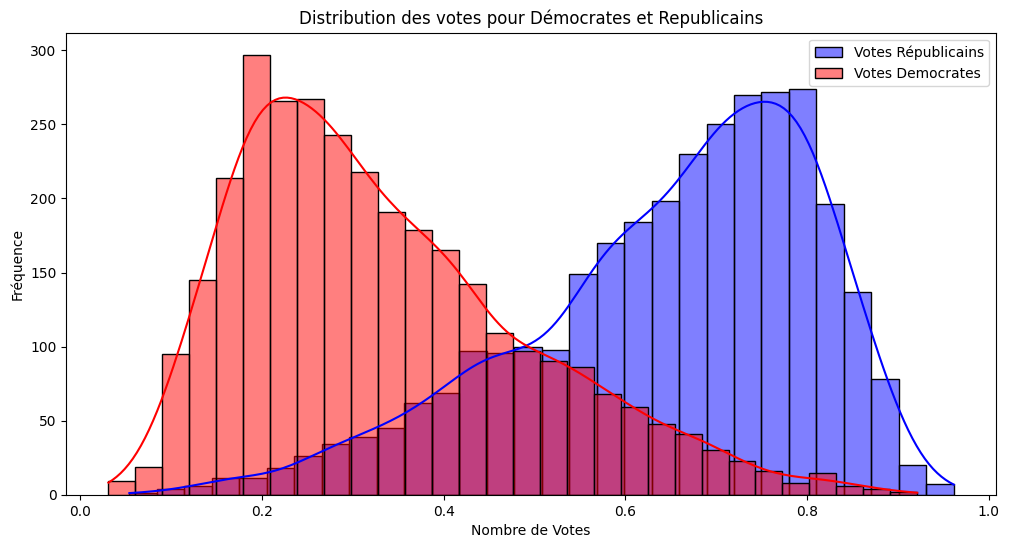

In [59]:
plt.figure(figsize=(12, 6))
sns.histplot(df['per_gop'], bins=30, color='blue', label='Votes Républicains', kde=True)
sns.histplot(df['per_dem'], bins=30, color='red', label='Votes Democrates', kde=True)
plt.title('Distribution des votes pour Démocrates et Republicains')
plt.xlabel('Nombre de Votes')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

#### **Analyse du graphique :**  
**Répartition des votes :**  
   - La **courbe rouge** (votes démocrates) montre que la majorité des comtés ont un pourcentage de votes démocrates autour de **20% à 40%**.  
   - La **courbe bleue** (votes républicains) indique que la plupart des comtés ont un pourcentage de votes républicains situé entre **60% et 80%**.  

**Asymétrie des distributions :**  
   - La distribution des **votes démocrates** est **concentrée vers les faibles pourcentages** (majorité des comtés votent peu pour les démocrates).  
   - La distribution des **votes républicains** est plus large et montre un **pic élevé vers 70%**, indiquant qu’ils dominent dans de nombreux comtés.  

**Zone de chevauchement (40%-60%) :**  
   - Entre **40% et 60%**, on observe un **chevauchement des distributions**, ce qui représente des comtés où l’élection a été plus serrée.  
   - Toutefois, cette zone est plus réduite, suggérant que peu de comtés sont véritablement compétitifs.  

Donc en conclusion, on peut affirmer que :
- La majorité des comtés ont une forte proportion de votes républicains.  
- Les démocrates ont des résultats élevés dans une minorité de comtés.  
- Les élections sont rarement équilibrées au niveau des comtés, la plupart penchant fortement d’un côté.  

On continue

 Via un boxplot, essayons de voir s’il existe une différence significative dans les niveaux de chômage en fonction du parti qui a remporté le comté.

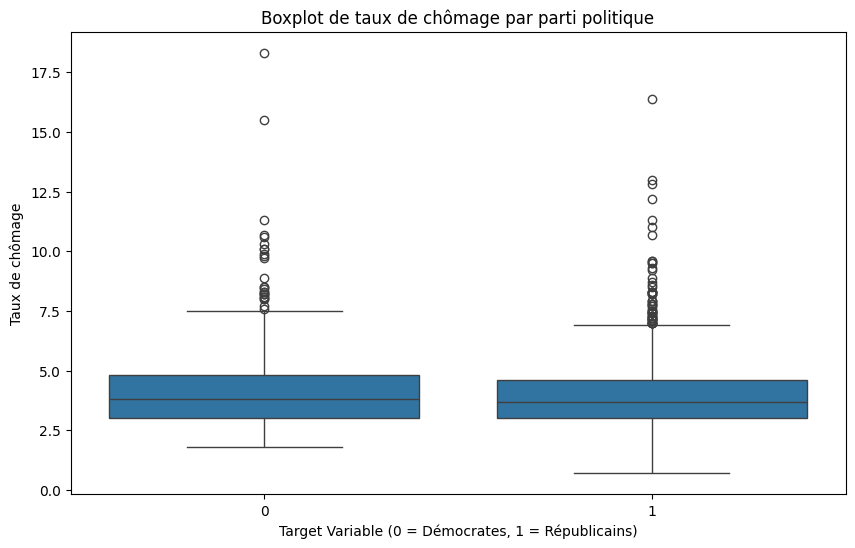

In [60]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='unemployment_rate', data=df)
plt.title('Boxplot de taux de chômage par parti politique')
plt.xlabel('Target Variable (0 = Démocrates, 1 = Républicains)')
plt.ylabel('Taux de chômage')
plt.show()

#### **Analyse des résultats :**  
**Distribution similaire** :  
   - Les **médianes** des deux groupes sont très proches (autour de **4% à 5%**).  
   - L’**étendue interquartile (IQR, entre Q1 et Q3)** est également très similaire pour les deux partis.  

**Présence d’outliers** :  
   - Dans les deux cas, on observe des **outliers élevés**, représentant des comtés avec un taux de chômage exceptionnellement haut (supérieur à **10-15%**).  
   - Ces comtés sont rares mais existent aussi bien chez les démocrates que chez les républicains.  

---
 
- **Le taux de chômage ne semble pas être un facteur distinctif majeur** entre les comtés démocrates et républicains. Les distributions sont globalement similaires.  
- **Les outliers montrent qu’il existe des comtés en difficulté économique**, mais ils sont répartis dans les deux groupes.  

D'autres variables économiques pourraient être plus discriminantes, comme le revenu médian ou le niveau d’éducation donc essayons de voir dans la suite.  


---

Notre dataframe a des colonnes suivantes :

```python
Index(['county_code', 'county_name', 'state_name', 'state_code', 'per_gop',
       'per_dem', 'rural_urban_code', 'urban_influence_code',
       'percent_no_highschool', 'percent_highschool', 'percent_college',
       'percent_bachelor', 'percent_poverty', 'median_household_income',
       'unemployment_rate', 'Employed_2019', 'Unemployed_2019', 'target'],
      dtype='object')
```

On va exclure les colonnes qui ne sont **pas des variables quantitatives pertinentes** pour notre analyse avec un boxplot.  

---

#### **Sélection des colonnes à analyser**  
On exclut :  
- **Identifiants** : `county_code`, `county_name`, `state_name`, `state_code` (ce ne sont pas des variables numériques pertinentes)  
- **Les variables cibles** : `per_gop`, `per_dem` (car ce sont des proportions des votes, et non des caractéristiques socio-économiques)  
- **La variable catégorielle** : `rural_urban_code`, `urban_influence_code` (ces codes sont discrets et ne conviennent pas bien à un boxplot)

---

#### **Variables à inclure dans les boxplots**  
On va comparer ces variables en fonction du **vote (target = 0 pour Démocrate, 1 pour Républicain)** :  

- **Éducation**  
   - `percent_no_highschool` (Taux de personnes sans diplôme du secondaire)  
   - `percent_highschool` (Taux de diplômés du secondaire)  
   - `percent_college` (Taux de personnes avec un diplôme universitaire)  
   - `percent_bachelor` (Taux de diplômés d’un Bac +4 ou plus)  

- **Économie et pauvreté**  
   - `percent_poverty` (Taux de pauvreté)  
   - `median_household_income` (Revenu médian des ménages)  
   - `unemployment_rate` (Taux de chômage)  

- **Emploi**  
   - `Employed_2019` (Nombre d’emplois en 2019)  
   - `Unemployed_2019` (Nombre de chômeurs en 2019)  

---


Comme fait précédemment avec `unemloyment_rate`(taux de chômage), on va tracer un **boxplot pour chaque variable** en fonction du vote (`target`). Cela permettra de voir :  
- **Les différences de distribution entre comtés démocrates et républicains**  
- **Les tendances socio-économiques des zones rouges et bleues**  
- **Quels facteurs montrent de vraies différences selon le vote**  


In [61]:
columns_to_plot = [
    'percent_no_highschool', 'percent_highschool', 'percent_college', 'percent_bachelor',
    'percent_poverty', 'median_household_income', 'unemployment_rate',
    'Employed_2019', 'Unemployed_2019'
]

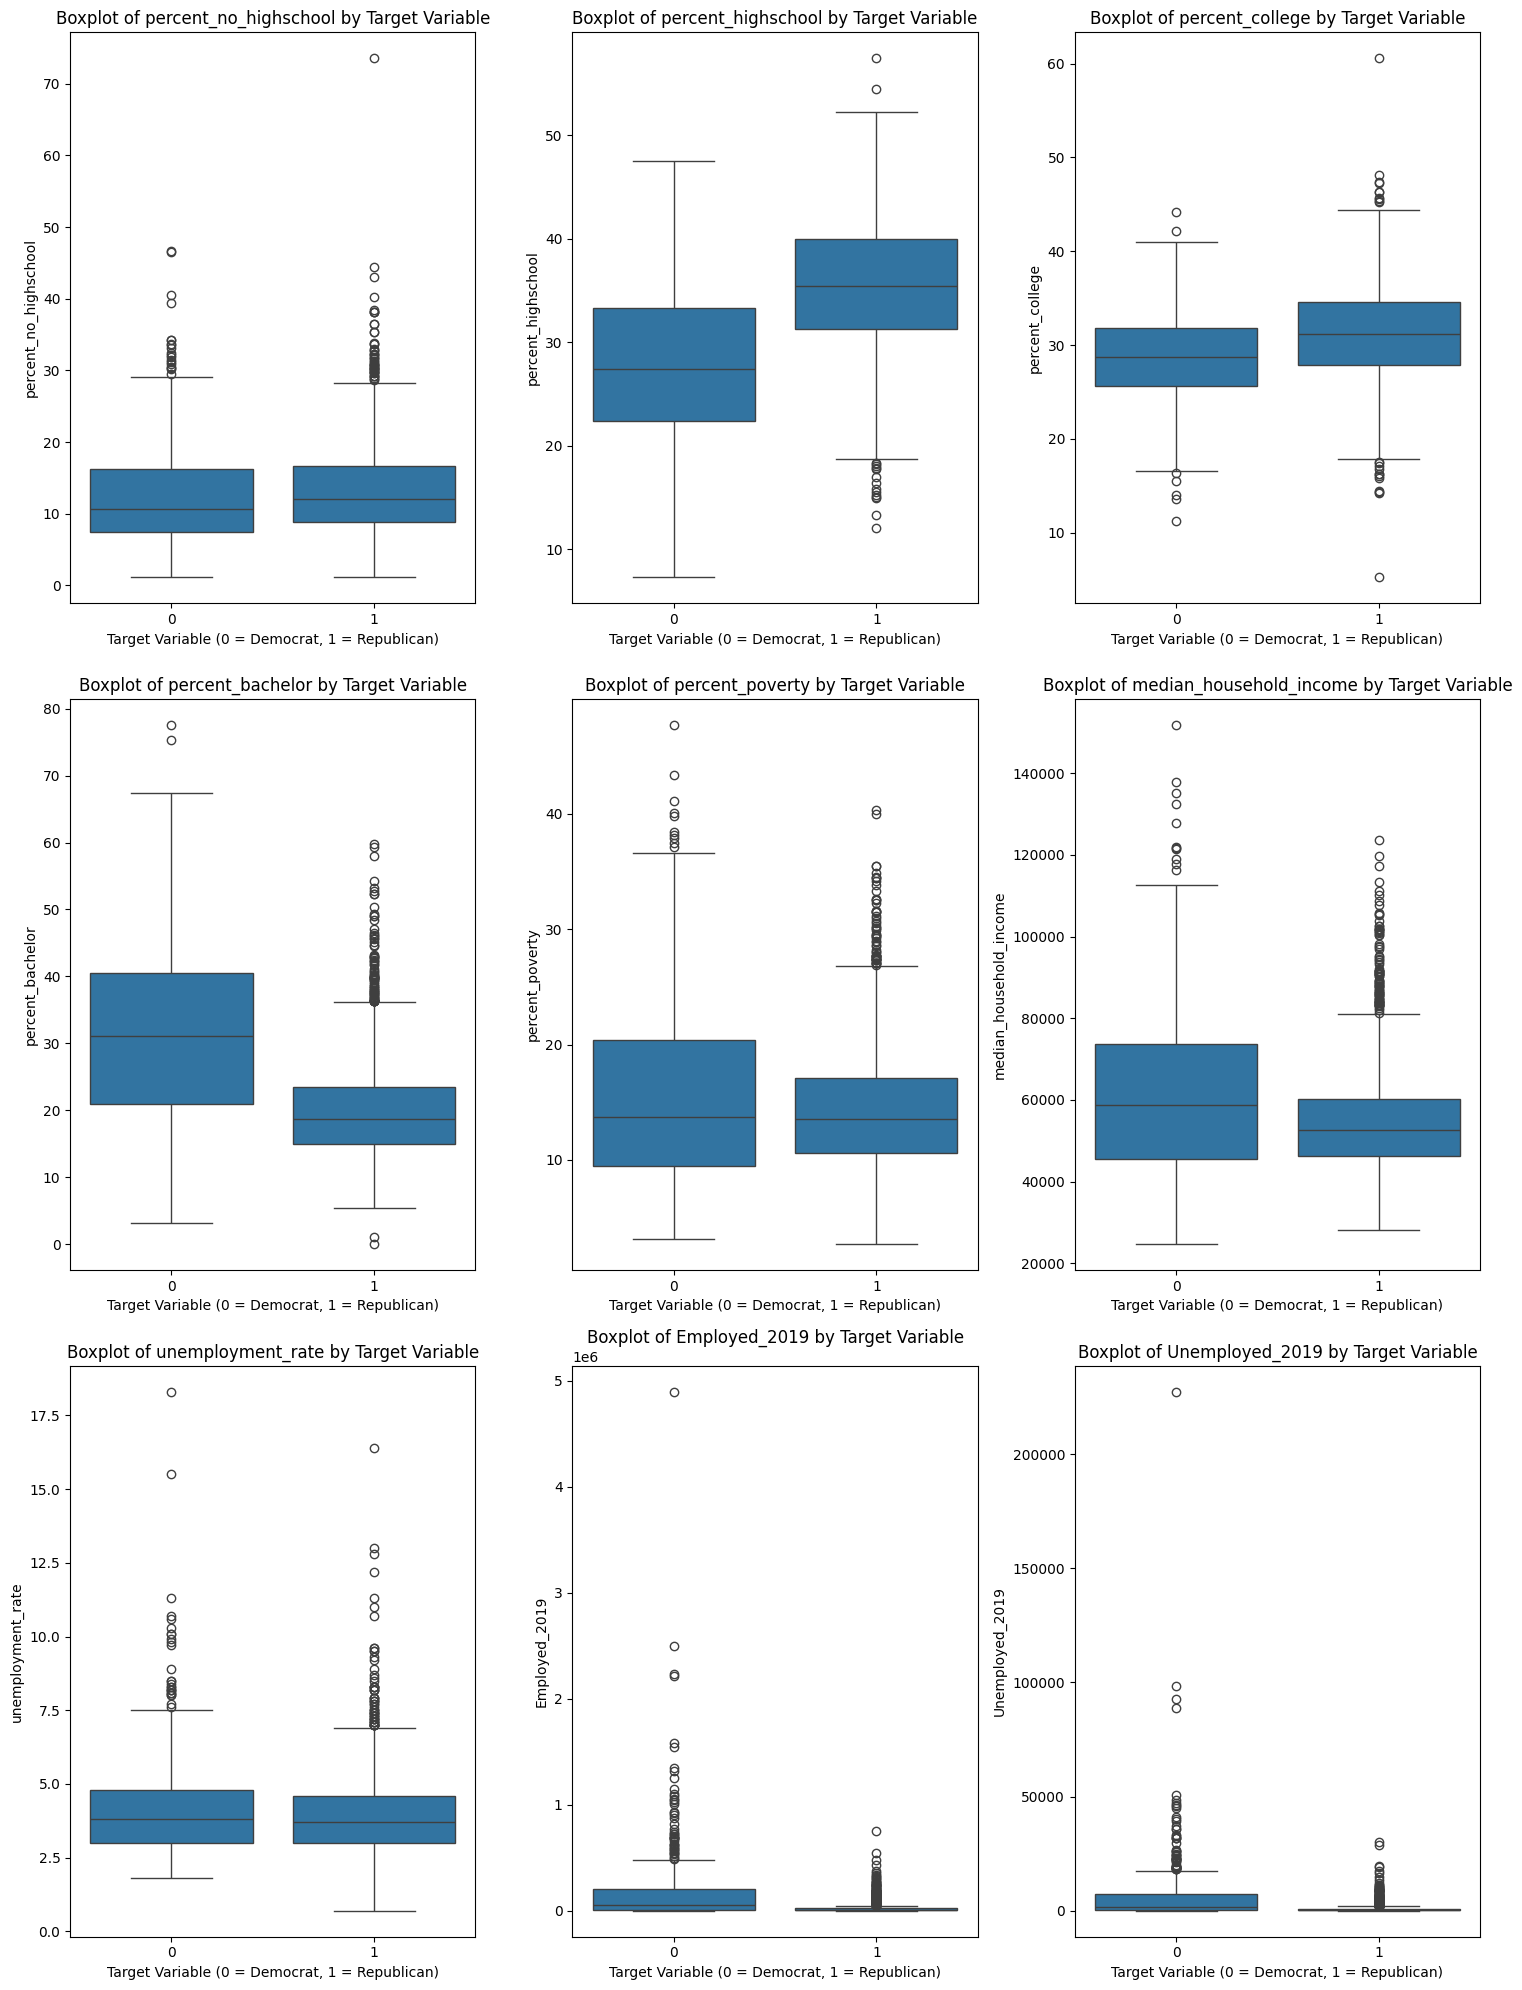

In [62]:
plt.figure(figsize=(15, 20))

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='target', y=col, data=df)
    plt.title(f'Boxplot of {col} by Target Variable')
    plt.xlabel('Target Variable (0 = Democrat, 1 = Republican)')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

Avant de procéder à l'interprétation des ce graphique, on note que les variables `Employed_2019` et `Unemployed_2019` ont des valeurs très élevées (de l’ordre de millions), ce qui entraîne une distribution très asymétrique et rend difficile l’interprétation des différences entre groupes.

* Solution : Appliquer une transformation logarithmique (log10 ou log1p) pour réduire l’échelle et mieux distinguer les tendances.

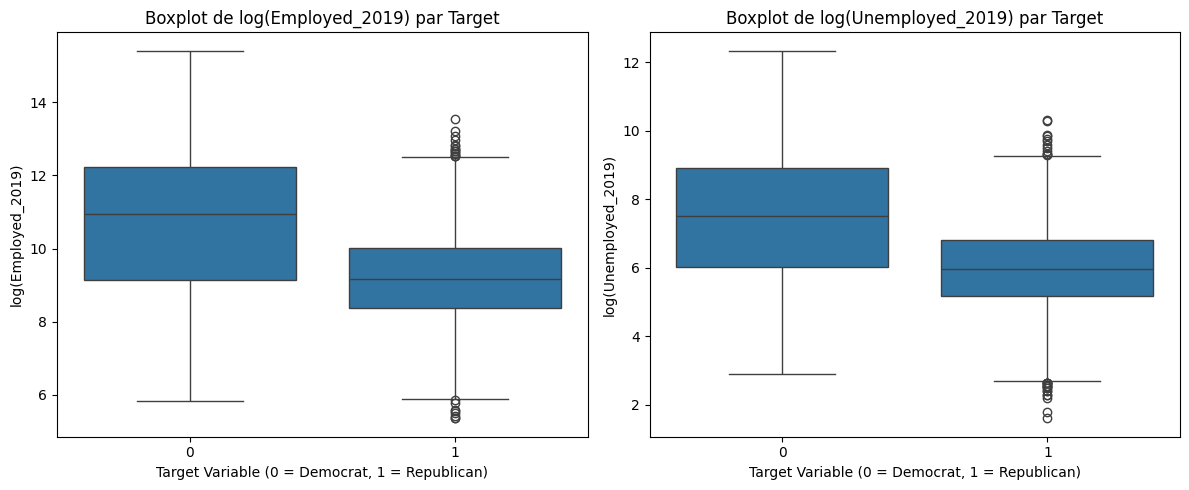

In [63]:
plt.figure(figsize=(12, 5))

# Boxplot pour Employed_2019 en log
plt.subplot(1, 2, 1)
sns.boxplot(x='target', y=np.log1p(df['Employed_2019']), data=df)
plt.title('Boxplot de log(Employed_2019) par Target')
plt.xlabel('Target Variable (0 = Democrat, 1 = Republican)')
plt.ylabel('log(Employed_2019)')

# Boxplot pour Unemployed_2019 en log
plt.subplot(1, 2, 2)
sns.boxplot(x='target', y=np.log1p(df['Unemployed_2019']), data=df)
plt.title('Boxplot de log(Unemployed_2019) par Target')
plt.xlabel('Target Variable (0 = Democrat, 1 = Republican)')
plt.ylabel('log(Unemployed_2019)')

plt.tight_layout()
plt.show()

On voit maintenant que c'est plus claire

#### Analyse des graphiques précédents

Voici quelques observations clés :  

---

##### **Éducation**  
-  **`percent_no_highschool`** (Taux de non-diplômés)  
   Un peu plus élevé dans les comtés républicains.  
   La médiane est légèrement plus haute pour `target=1` (Républicains).  
-  **`percent_highschool`** (Taux de diplômés du secondaire)  
   Très similaire entre les deux groupes, mais une légère tendance à être plus élevé chez les Républicains.  
-  **`percent_college` et `percent_bachelor`** (Taux de diplômés universitaires et bac +4)  
   Les comtés démocrates ont généralement un taux plus élevé d'éducation supérieure.  
   La médiane est plus haute pour `target=0` (Démocrates), suggérant un lien entre niveau d’éducation élevé et vote démocrate.  

---

##### **Économie & Pauvreté**  
-  **`percent_poverty`** (Taux de pauvreté)  
   Assez similaire entre les deux groupes.  
   Il y a plus d’**outliers** avec un taux de pauvreté très élevé dans les comtés démocrates.  
-  **`median_household_income`** (Revenu médian des ménages)  
   La **médiane est légèrement plus haute dans les comtés démocrates**, indiquant un revenu plus élevé dans ces zones.  
   Distribution plus étendue pour les démocrates, avec des comtés riches et pauvres.  

---

##### **Emploi & Chômage**  
-  **`unemployment_rate`** (Taux de chômage)  
   Pas de différence majeure entre démocrates et républicains.  
   Beaucoup d’outliers, ce qui indique que certains comtés connaissent un **chômage très élevé**.  
-  **`Employed_2019` & `Unemployed_2019`**  
   Les comtés démocrates ont des valeurs plus élevées

---

##### **Conclusion & Interprétation**  
- **L’éducation semble être un facteur clé** : plus de diplômés du supérieur dans les comtés démocrates.  
- **Le revenu médian est légèrement plus élevé chez les démocrates**.  
- **Peu de différences sur le chômage et la pauvreté**, mais plus d’outliers chez les démocrates.  
- **Les comtés démocrates ont plus d’emplois en volume**, ce qui est cohérent avec la présence de grandes villes.  

Ces insights peuvent nous aider à comprendre quelles variables sont les plus discriminantes pour notre modèle de classification. 

On note quand même des **indices** précieux sur les variables qui pourraient être les plus discriminantes pour notre modèle de classification. Voici quelques éléments clés que nous pouvons en tirer pour identifier les **variables les plus importantes** :

##### 1. **Éducation :**
   - Les variables liées au **niveau d’éducation** (comme `percent_no_highschool`, `percent_highschool`, `percent_college`, `percent_bachelor`) montrent une **différence notable** entre les comtés démocrates et républicains.  
   - **Observation clé :** Les comtés démocrates semblent avoir un taux plus élevé de diplômés universitaires (bachelor et college).

##### 2. **Pauvreté et Revenu :**
   - Le **taux de pauvreté** (`percent_poverty`) et le **revenu médian des ménages** (`median_household_income`) montrent aussi des différences.  
   - **Observation clé :** Les comtés démocrates ont tendance à avoir des revenus plus élevés, mais avec une distribution plus variée. Le taux de pauvreté semble plus homogène, mais les comtés démocrates ont plus d’**outliers** (extrêmes).


##### **Analyse des variables les plus discriminantes :**
- **Éducation :** Les variables comme `percent_bachelor`, `percent_college` et `percent_no_highschool` semblent avoir une **forte capacité discriminante**.  
- **Revenu :** `median_household_income` est une bonne candidate pour être une variable discriminante dans la mesure où elle montre une **différence nette** entre les comtés démocrates et républicains.  
- **Taux de chômage et d’emploi :** Ces variables ne sont pas aussi discriminantes sur le plan visuel, mais elles peuvent avoir un effet sur les régions moins peuplées ou dans les zones où l’emploi joue un rôle central.  
- **Pauvreté :** Bien que le taux de pauvreté ait quelques différences, son impact pourrait être **moins marquant** que l’éducation et le revenu.

Mais on verra tout cela dans la suite de notre notebook

---
### 4.2. Calcul de la corrélation entre les variables
Maintenant on va procéder au calcul des corrélation entre ces variables et la variable cible (target) histoire d'affiner nos insights.

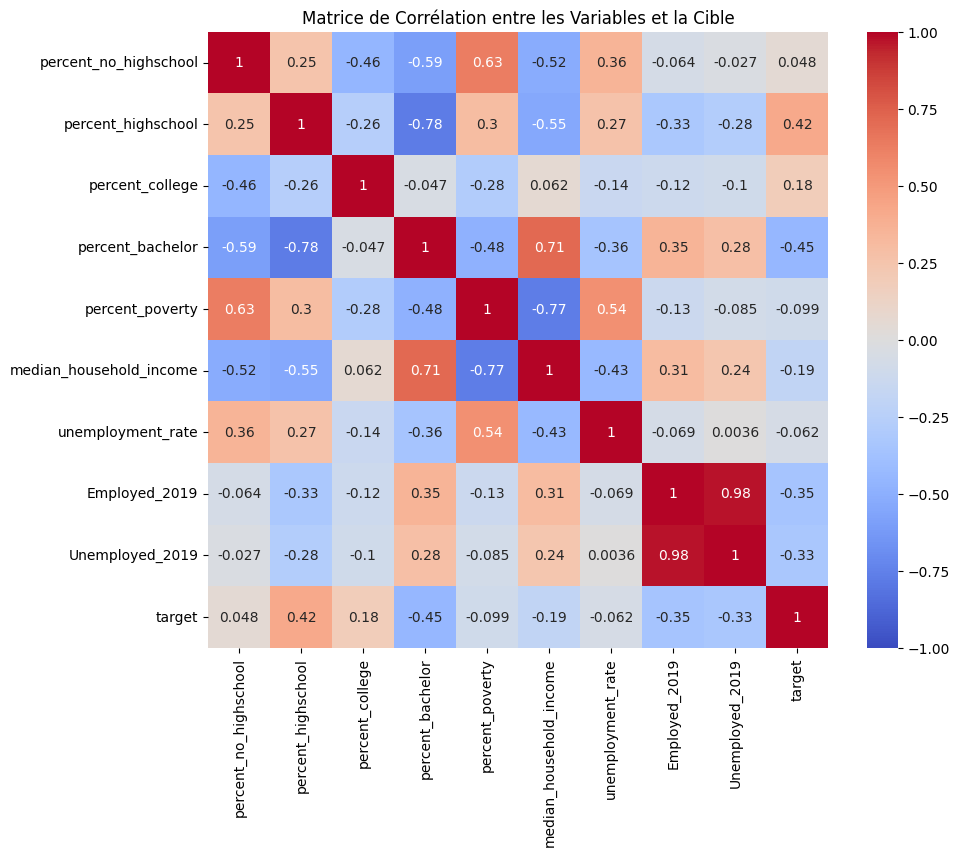

In [64]:
df_corr = df[columns_to_plot + ['target']]

# Calcul de la corrélation de Pearson
corr_matrix = df_corr.corr()

# Visualisation de la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice de Corrélation entre les Variables et la Cible')
plt.show()

---
## 5. MODELISATION

### 5.1. CheckUps

Checking de la repartition des votes 

In [65]:
df["target"].value_counts(normalize=True)

target
1    0.823287
0    0.176713
Name: proportion, dtype: float64

Observation :
Le dataset est très déséquilibré :

- 82.3% des comtés ont voté Républicain (1)
- 17.7% ont voté Démocrate (0)
##### Cela peut poser problème, car un modèle de classification risque de favoriser la classe majoritaire et mal prédire les Démocrates.

---

##### Séparation features et target

In [66]:
df.columns

Index(['county_code', 'county_name', 'state_name', 'state_code', 'per_gop',
       'per_dem', 'rural_urban_code', 'urban_influence_code',
       'percent_no_highschool', 'percent_highschool', 'percent_college',
       'percent_bachelor', 'percent_poverty', 'median_household_income',
       'unemployment_rate', 'Employed_2019', 'Unemployed_2019', 'target'],
      dtype='object')

In [67]:
X = df.drop(columns=["target", "per_gop", "per_dem"])  # On enlève la cible et les variables trop corrélées
y = df["target"]

##### Encodage des variables catégorielles

In [68]:

categorical_features = ["state_name", "state_code", "county_name"]
encoder = OneHotEncoder(drop="first", sparse_output=False)
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_features]))

##### Ajout des autres features numériques

In [69]:
X_numeric = X.drop(columns=categorical_features).reset_index(drop=True)
X_encoded = pd.concat([X_numeric, X_encoded], axis=1)

##### Division en train/test

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

In [71]:
X_train

,county_code,rural_urban_code,urban_influence_code,percent_no_highschool,percent_highschool,percent_college,percent_bachelor,percent_poverty,median_household_income,unemployment_rate,...,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985
1637,30059,9.0,10.0,4.790419,40.269463,25.673653,29.266466,15.7,43946.0,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1259,26037,2.0,2.0,5.485960,26.770967,35.655029,32.088043,7.8,72666.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2041,38083,9.0,12.0,12.488522,37.465565,35.445362,14.600551,16.7,58725.0,4.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
662,17115,3.0,2.0,9.584462,35.408043,32.919765,22.087729,16.7,52259.0,5.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3032,54061,3.0,2.0,7.635044,27.206993,22.314768,42.843197,19.1,55652.0,3.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1871,36067,2.0,2.0,8.987964,25.394932,29.727617,35.889488,13.8,61597.0,3.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
761,18109,1.0,1.0,11.889562,39.308514,31.550037,17.251886,8.9,63414.0,3.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
545,13299,5.0,8.0,18.608547,39.218891,27.016096,15.156467,26.3,37642.0,3.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2376,46011,5.0,8.0,4.960242,25.217720,29.485584,40.336452,11.9,59036.0,3.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
X_test

,county_code,rural_urban_code,urban_influence_code,percent_no_highschool,percent_highschool,percent_college,percent_bachelor,percent_poverty,median_household_income,unemployment_rate,...,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985
286,8061,9.0,12.0,4.317269,35.642570,38.654617,21.385542,13.5,46901.0,1.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2503,47131,7.0,8.0,16.482586,44.771351,23.419655,15.326408,14.6,44061.0,4.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1439,28057,7.0,8.0,20.921354,31.114788,34.805294,13.158565,12.8,49214.0,4.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
903,20011,6.0,4.0,8.677859,31.479538,38.163692,21.678909,15.6,47452.0,4.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168,5093,4.0,3.0,18.850685,38.846279,28.465010,13.838024,23.0,39990.0,5.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,19173,9.0,10.0,9.824150,38.475967,37.233295,14.466589,12.5,51510.0,1.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2757,48449,7.0,8.0,23.306873,33.405346,26.944332,16.343449,16.3,49924.0,4.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
322,9007,1.0,1.0,5.785491,25.818508,26.245884,42.150116,7.0,81721.0,3.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
388,12115,2.0,2.0,6.905650,28.914724,28.762798,35.416828,7.8,66258.0,3.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
# Vérification
X_train.shape, X_test.shape, y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)


((2521, 1998),
 (631, 1998),
 target
 1    0.823483
 0    0.176517
 Name: proportion, dtype: float64,
 target
 1    0.822504
 0    0.177496
 Name: proportion, dtype: float64)

Analyse des résultats :
- Taille des datasets :
- Train : 2521 lignes, Test : 631 lignes →  OK
- Nombre de features après encodage : 1999 → ça semble normal (One-Hot Encoding a ajouté beaucoup de colonnes)
- Répartition des classes :
- Train : 82.3% Républicain / 17.7% Démocrate
- Test : 82.2% Républicain / 17.8% Démocrate
- L'équilibre est bien conservé après le split → c’est bon pour l’apprentissage !


### 5.2. Premier essai avec La Regression Logistique

Nous commençons par un **modèle de base** avec une **Régression Logistique**.  
Cette étape est **obligatoire** dans le projet pour servir de référence avant d'essayer des modèles plus avancés.  


Ajout du `target` et retrait du `is_state`

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)


# Initialisation du modèle
model = LogisticRegression(max_iter=1000, random_state=42)

# Entraînement
model.fit(X_train, y_train)

# Prédiction sur le test set
y_pred = model.predict(X_test)

# Évaluation des performances
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.51      0.62       112
           1       0.90      0.97      0.93       519

    accuracy                           0.89       631
   macro avg       0.84      0.74      0.78       631
weighted avg       0.88      0.89      0.88       631



/home/raouf/workspaces/personal/courses/datagong/mvenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 5.3. Test du Sous-échantillonnage (Undersampling)
On réduit la classe majoritaire (Républicains) pour équilibrer les proportions.

In [75]:
from sklearn.utils import resample

# Séparation des classes les classes
df_majority = df_cleaned[df_cleaned["target"] == 1]  # Républicains
df_minority = df_cleaned[df_cleaned["target"] == 0]  # Démocrates

# Undersampling : réduiction de la classe majoritaire à la taille de la minoritaire
df_majority_downsampled = resample(df_majority, 
                                   replace=False,  
                                   n_samples=len(df_minority),  
                                   random_state=42)

# Fusion
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Check de la distribution des classes après undersampling
print(df_balanced["target"].value_counts(normalize=True))


target
1    0.5
0    0.5
Name: proportion, dtype: float64


### 5.4. Test du Sur-échantillonnage (SMOTE)
Avec SMOTE, on crée artificiellement des observations pour la classe minoritaire.

In [76]:
# Appliquons SMOTE
smote = SMOTE(random_state=42)
X_encoded.columns = X_encoded.columns.astype(str)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# Vérification de la nouvelle distribution des classes
print(pd.Series(y_resampled).value_counts(normalize=True))


target
1    0.5
0    0.5
Name: proportion, dtype: float64


### 5.5. Regression Logistique : 2e essaie (après echantillonage)

Prochaine étape : Réentraîner le modèle et comparer les résultats
Maintenant, on va :
- Réentraîner la Régression Logistique avec SMOTE.
- Comparer les nouvelles performances avec celles de notre premier modèle (sans correction).

In [77]:
# Réentraîner le modèle avec les données équilibrées (SMOTE)
model_smote = LogisticRegression(max_iter=500, random_state=42)
model_smote.fit(X_resampled, y_resampled)

# Prédire sur le test set d'origine (X_test, y_test)
y_pred_smote = model_smote.predict(X_test)

# Afficher les nouvelles performances
print(classification_report(y_test, y_pred_smote))


              precision    recall  f1-score   support

           0       0.52      0.77      0.62       112
           1       0.94      0.85      0.89       519

    accuracy                           0.83       631
   macro avg       0.73      0.81      0.76       631
weighted avg       0.87      0.83      0.85       631



/home/raouf/workspaces/personal/courses/datagong/mvenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### **Analyse comparative des résultats de la Regression Logistique avant et après echantillonage**

Voici le tableau correctement complété avec les nouvelles valeurs après SMOTE :  

| Modèle                          | Précision (Démocrates) | Recall (Démocrates) | F1-Score (Démocrates) | Précision (Républicains) | Recall (Républicains) | F1-Score (Républicains) | Accuracy globale |
|---------------------------------|------------------------|----------------------|------------------------|------------------------|----------------------|------------------------|----------------|
| **Régression Logistique**        | 0.78                   | 0.51                 | 0.62                   | 0.90                   | 0.97                 | 0.93                   | 0.89           |
| **Régression Logistique (SMOTE)** | 0.52                   | 0.77                 | 0.62                   | 0.94                   | 0.85                 | 0.89                   | 0.83           |

#### **Interprétation des résultats**  
- **Le recall des Démocrates (0) est passé de 0.51 à 0.77 !**  
- **Mais la précision des Démocrates a chuté de 0.78 à 0.52**, ce qui signifie que le modèle fait plus d’erreurs en prédisant des Démocrates.  
- **L’accuracy globale a légèrement baissé (0.89 → 0.83),** mais c’est normal, car le modèle ne favorise plus autant les Républicains.  

**En résumé :**
- Avant SMOTE, le modèle **détectait mal les Démocrates** (mauvais recall).  
- Après SMOTE, il **détecte mieux les Démocrates**, mais **fait plus d’erreurs** en les classant.  
- Le modèle devient **plus équilibré**, mais il faudrait tester d'autres techniques pour améliorer encore la précision des Démocrates.  

### 5.6. Random Forest

Après la regression logistique, on va essayer le Random Forest en espérant avoir un meilleur score de précision et de recall.

##### Convertissons les noms de colonnes en chaînes de caractères pour X_resampled et X_test


In [61]:
X_resampled.columns = X_resampled.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

##### Entraînement du modèle RandomForest

In [62]:
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)

In [ ]:
#rf_model.fit(X_train, y_train)

In [63]:
# Entrainement sur les sonnées SMOTE
rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)

##### Prédiction et Evaluation des résultats

In [64]:
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.72      0.75      0.73       112
           1       0.95      0.94      0.94       519

    accuracy                           0.90       631
   macro avg       0.83      0.84      0.84       631
weighted avg       0.91      0.90      0.90       631



#### Tableau mis à jour avec les résultats pour **Random Forest** :  



| Modèle                          | Précision (Démocrates) | Recall (Démocrates) | F1-Score (Démocrates) | Précision (Républicains) | Recall (Républicains) | F1-Score (Républicains) | Accuracy globale |
|---------------------------------|------------------------|----------------------|------------------------|------------------------|----------------------|------------------------|----------------|
| **Régression Logistique**        | 0.78                   | 0.51                 | 0.62                   | 0.90                   | 0.97                 | 0.93                   | 0.89           |
| **Régression Logistique (SMOTE)** | 0.52                   | 0.77                 | 0.62                   | 0.94                   | 0.85                 | 0.89                   | 0.83           |
| **Random Forest**                | 0.72                   | 0.75                 | 0.73                   | 0.95                   | 0.94                 | 0.94                   | 0.90           |

### 5.7. Optimisation du Random Forest avec GridSearchCV
Le but est de trouver les meilleurs hyperparamètres en testant plusieurs combinaisons.

##### Construction du pipeline : SMOTE suivi du Random Forest

In [78]:
# Construction du pipeline : SMOTE suivi du Random Forest
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Définition de la grille d'hyperparamètres à tester
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5, 10]
}

# Mise en place de GridSearchCV avec 5-fold cross-validation et en utilisant le F1_macro comme score
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres et du meilleur score obtenu
print("Meilleurs paramètres : ", grid_search.best_params_)
print("Meilleur F1_macro : ", grid_search.best_score_)

# Évaluation du meilleur modèle sur le jeu de test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


Meilleurs paramètres :  {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Meilleur F1_macro :  0.8350521032530501
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       112
           1       0.93      0.95      0.94       519

    accuracy                           0.90       631
   macro avg       0.83      0.82      0.82       631
weighted avg       0.90      0.90      0.90       631



Recapitulatif

| Modèle                              | Précision (Démocrates) | Recall (Démocrates) | F1-Score (Démocrates) | Précision (Républicains) | Recall (Républicains) | F1-Score (Républicains) | Accuracy globale |
|-------------------------------------|------------------------|----------------------|------------------------|------------------------|----------------------|------------------------|----------------|
| **Régression Logistique**           | 0.78                   | 0.51                 | 0.62                   | 0.90                   | 0.97                 | 0.93                   | 0.89           |
| **Régression Logistique (SMOTE)**    | 0.52                   | 0.77                 | 0.62                   | 0.94                   | 0.85                 | 0.89                   | 0.83           |
| **Random Forest**                    | 0.72                   | 0.75                 | 0.73                   | 0.95                   | 0.94                 | 0.94                   | 0.90           |
| **Random Forest (Grid Search)**      | 0.73                   | 0.69                 | 0.71                   | 0.93                   | 0.95                 | 0.94                   | 0.90           |

Analysons l'Importance des Variables
Une fois le meilleur modèle identifié, nous pourrons analyser l'importance globale des variables. Pour Random Forest, l'attribut `feature_importances_` permet d'identifier l'impact de chaque feature.

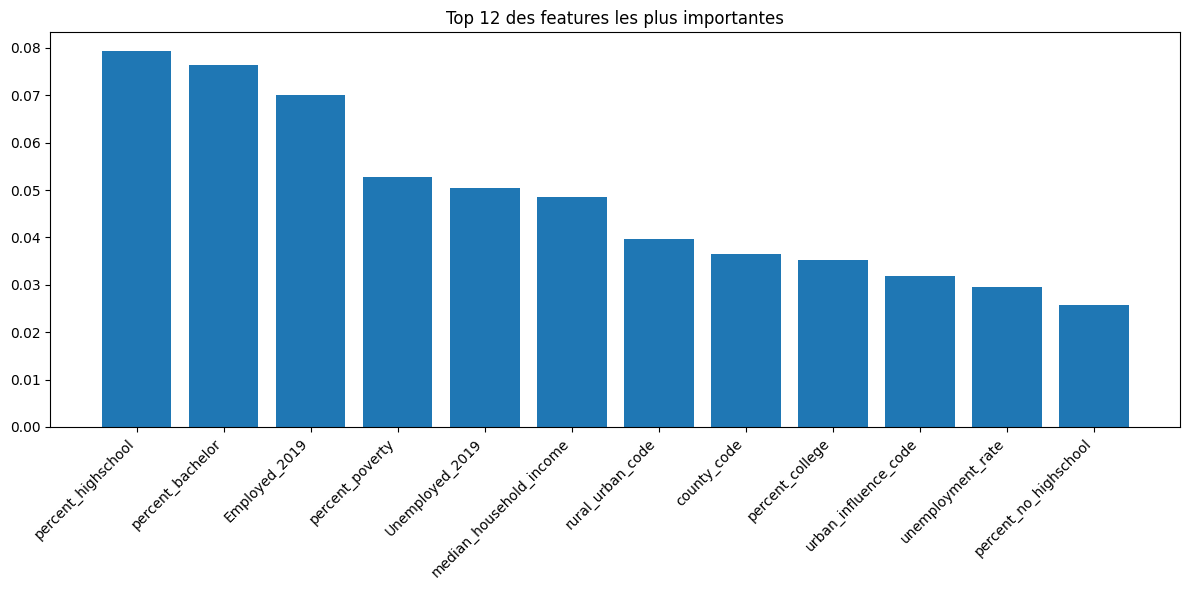

In [81]:
# Récupération et trie des importances des features
importances = best_model.named_steps['rf'].feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

# Nombre de features à afficher (Pour éviter le chevauchement à cause du nombre de variables)
n_features = 12

plt.figure(figsize=(12, 6))
plt.title("Top 12 des features les plus importantes")
plt.bar(range(n_features), importances[indices][:n_features], align='center')
plt.xticks(range(n_features), np.array(features)[indices][:n_features], rotation=45, ha="right")
plt.tight_layout()
plt.show()

Ce graphe représente les 12 variables les plus importantes utilisées par le modèle Random Forest (`rf`) pour prédire le parti politique victorieux (Démocrate ou Républicain) dans un comté.

##### Interprétation :
1. **Les variables éducatives sont dominantes**  
   - `percent_highschool` (taux de diplômés du lycée) et `percent_bachelor` (taux de diplômés d’une licence) sont les deux variables les plus importantes.  
   - Cela indique que le niveau d’éducation a une forte influence sur les résultats électoraux.

2. **L’emploi et la pauvreté jouent un rôle clé**  
   - `Employed_2019` (nombre d’employés en 2019) et `Unemployed_2019` (nombre de chômeurs en 2019) sont également des facteurs importants.  
   - De même, `percent_poverty` (taux de pauvreté) et `median_household_income` (revenu médian des ménages) apparaissent comme déterminants.

3. **L’urbanisation est un facteur influent**  
   - `rural_urban_code` et `urban_influence_code` indiquent que le degré d’urbanisation d’un comté a un impact sur le vote.
   - En général, les zones urbaines votent davantage pour les Démocrates, tandis que les zones rurales sont plus favorables aux Républicains.

4. **D’autres variables influencent aussi**  
   - `county_code` semble avoir une importance, mais cela peut être dû à une corrélation avec d’autres caractéristiques locales.
   - `unemployment_rate` est présent mais moins influent que d'autres indicateurs économiques.

##### Conclusion :
Le graphe montre que l'éducation, l'emploi, la pauvreté et l’urbanisation sont les principaux déterminants du vote dans cette élection. Cela est cohérent avec les tendances politiques observées aux États-Unis, où les zones plus éduquées et urbaines tendent à voter démocrate, tandis que les zones rurales et économiquement fragiles sont souvent plus conservatrices.


* NB: On note aussi que les scores ne sont pas très élévé pour les démocrates.. On va donc essayer un modele plus performant (voir plus bas).

### 5.8. XG Boost

##### Initialisation du modèle XGBoost

In [89]:
xgb_model = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)

##### Entraînement sur les données équilibrées (SMOTE)

In [90]:
xgb_model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

##### Prédiction sur le test set d'origine

In [91]:
y_pred_xgb = xgb_model.predict(X_test)

##### Évaluation du modèle

In [92]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       112
           1       0.99      0.98      0.98       519

    accuracy                           0.97       631
   macro avg       0.95      0.96      0.95       631
weighted avg       0.97      0.97      0.97       631



#### Recapitulatif

Voici le tableau mis à jour avec les résultats de XGBoost :

| Modèle                              | Précision (Démocrates) | Recall (Démocrates) | F1-Score (Démocrates) | Précision (Républicains) | Recall (Républicains) | F1-Score (Républicains) | Accuracy globale |
|-------------------------------------|------------------------|----------------------|------------------------|------------------------|----------------------|------------------------|----------------|
| **Régression Logistique**           | 0.78                   | 0.51                 | 0.62                   | 0.90                   | 0.97                 | 0.93                   | 0.89           |
| **Régression Logistique (SMOTE)**    | 0.52                   | 0.77                 | 0.62                   | 0.94                   | 0.85                 | 0.89                   | 0.83           |
| **Random Forest**                    | 0.72                   | 0.75                 | 0.73                   | 0.95                   | 0.94                 | 0.94                   | 0.90           |
| **Random Forest (Grid Search)**      | 0.73                   | 0.69                 | 0.71                   | 0.93                   | 0.95                 | 0.94                   | 0.90           |
| **XGBoost**                         | 0.91                   | 0.94                 | 0.92                   | 0.99                   | 0.98                 | 0.98                   | 0.97           |

Donc en conclusion, XGBoost surpasse clairement tous les autres modèles testés avec:
- Une précision de 0.91 et un recall de 0.94 pour les Démocrates
- Une précision de 0.99 et un recall de 0.98 pour les Républicains
- Un F1-Score exceptionnel de 0.92 pour les Démocrates et 0.98 pour les Républicains
- Une accuracy globale de 0.97, bien supérieure aux autres modèles

XGBoost semble donc être le modèle le plus performant pour cette tâche de classification politique, avec un meilleur équilibre entre précision et recall, particulièrement pour la classe des Démocrates où les autres modèles avaient plus de difficultés.

#### Explainer avec shap

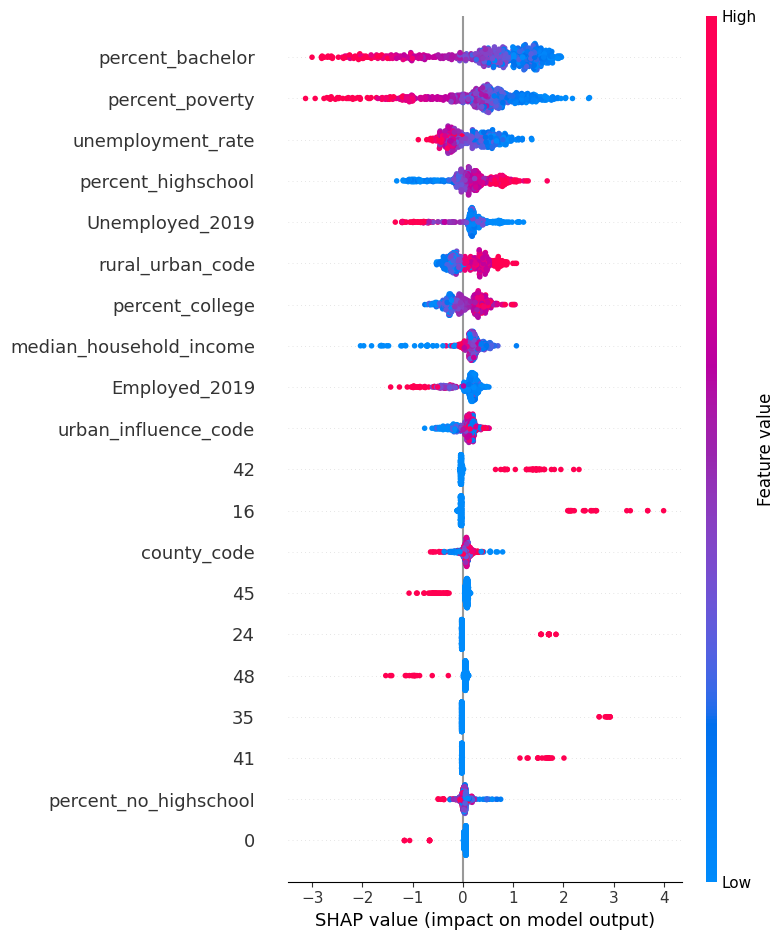

In [93]:
# Créer un explainer basé sur XGBoost avec correction du problème d'additivité
explainer = shap.TreeExplainer(xgb_model, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

# Afficher le summary plot pour voir les features les plus influentes
shap.summary_plot(shap_values, X_test)


Ce graphique représente un summary plot SHAP (SHapley Additive exPlanations) qui montre l'influence de différentes caractéristiques sur les prédictions du modèle XGBoost pour notre classification politique.

Les tendances les plus notables sont :

- **percent_bachelor** (pourcentage de personnes avec un diplôme universitaire) : C'est la variable la plus influente. Les valeurs élevées (rouge) poussent fortement vers la gauche (vote démocrate), tandis que les valeurs faibles (bleu) poussent vers la droite (vote républicain).

- **percent_poverty** : Des taux de pauvreté élevés (rouge) sont associés à une tendance démocrate, tandis que des taux plus faibles (bleu) sont associés à une tendance républicaine.

- **unemployment_rate** : Similaire au taux de pauvreté, un chômage plus élevé (rouge) est associé au vote démocrate.

- **percent_highschool** : De façon intéressante, un pourcentage élevé de diplômés du secondaire (rouge) est associé au vote républicain, ce qui peut refléter des zones avec une éducation moyenne mais non universitaire.

- **rural_urban_code** : Les zones plus urbaines (bleu) tendent vers les démocrates, tandis que les zones rurales (rouge) tendent vers les républicains.

Ces résultats confirment la tendance mentionnée précédemment : les zones plus éduquées (diplômes universitaires) et urbaines sont davantage associées au vote démocrate, tandis que les zones rurales et confrontées à certains défis économiques (mais pas nécessairement les plus pauvres) tendent davantage vers le vote républicain.


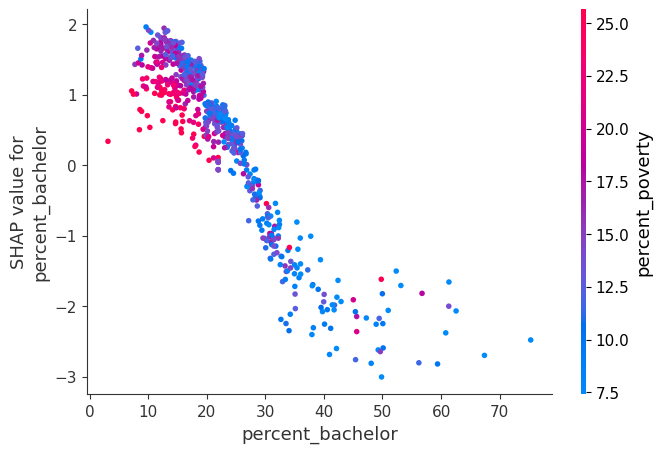

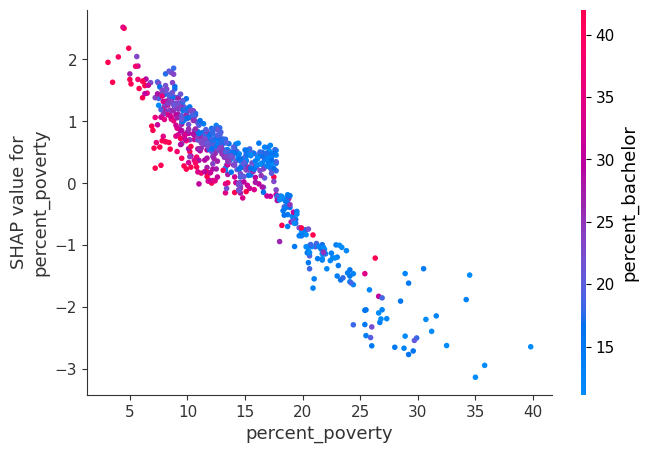

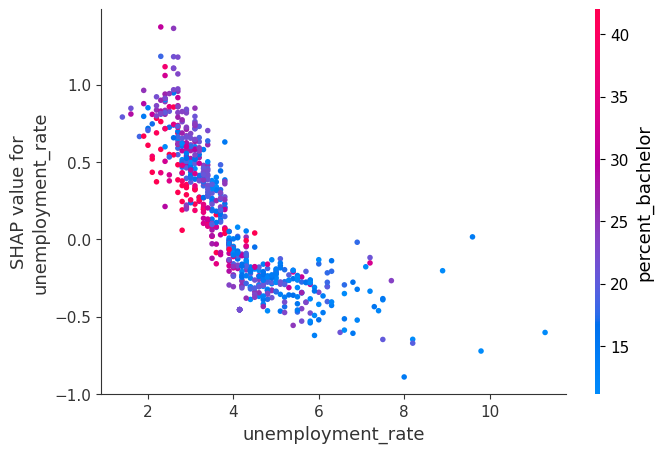

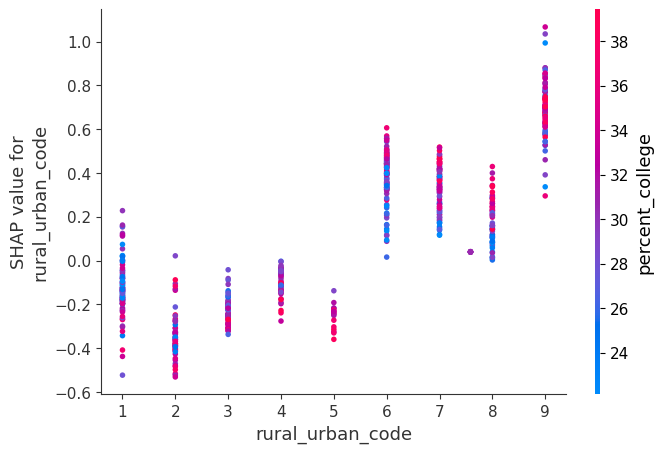

In [94]:
shap.dependence_plot("percent_bachelor", shap_values, X_test)
shap.dependence_plot("percent_poverty", shap_values, X_test)
shap.dependence_plot("unemployment_rate", shap_values, X_test)
shap.dependence_plot("rural_urban_code", shap_values, X_test)

Ces graphiques de dépendance SHAP illustrent les relations spécifiques entre certaines variables clés et leur impact sur les prédictions du modèle XGBoost. Voici l'analyse de chaque graphique :

**Image 1 - percent_bachelor** :
Ce graphique montre une forte relation négative entre le pourcentage de diplômés universitaires et les valeurs SHAP. Lorsque ce pourcentage est faible (0-20%), les valeurs SHAP sont positives (autour de +1 à +2), favorisant une prédiction républicaine. À l'inverse, lorsque le pourcentage dépasse 30-40%, les valeurs SHAP deviennent fortement négatives (jusqu'à -3), favorisant une prédiction démocrate. La coloration indique que les comtés avec des taux de pauvreté élevés (rouge) tendent à avoir un pourcentage plus faible de diplômés universitaires.

**Image 2 - percent_poverty** :
Ce graphique révèle également une relation négative : les comtés avec un taux de pauvreté élevé (>20%) ont tendance à avoir des valeurs SHAP négatives, favorisant une prédiction démocrate. À l'inverse, les comtés avec un faible taux de pauvreté (<10%) ont des valeurs SHAP positives, favorisant une prédiction républicaine. La coloration montre que les zones avec un taux de pauvreté élevé ont généralement un faible pourcentage de diplômés universitaires (bleu).

**Image 3 - unemployment_rate** :
La relation avec le taux de chômage est plus nuancée. Pour des taux de chômage faibles (2-4%), les valeurs SHAP sont positives, indiquant une tendance républicaine. Pour des taux plus élevés (>5%), les valeurs SHAP deviennent négatives, suggérant une tendance démocrate. On remarque également que les comtés avec un pourcentage élevé de diplômés universitaires (violet/rouge) ont généralement un taux de chômage plus bas.

**Image 4 - rural_urban_code** :
Ce graphique illustre l'impact du caractère rural ou urbain (où 1 représente les zones les plus urbaines et 9 les zones les plus rurales). Les codes 1-5 ont des valeurs SHAP négatives ou faibles, favorisant une prédiction démocrate, tandis que les codes 6-9 ont des valeurs SHAP positives, favorisant une prédiction républicaine. La transition est nette entre les zones plutôt urbaines et plutôt rurales. La coloration indique que les zones urbaines ont généralement un pourcentage plus élevé de diplômés universitaires.

Ces graphiques confirment et nuancent les observations précédentes : les zones urbaines, avec plus de diplômés universitaires et parfois des taux de pauvreté plus élevés, tendent vers le vote démocrate. Les zones rurales, avec moins de diplômés universitaires et des taux de chômage et de pauvreté variables, tendent vers le vote républicain. Cette analyse révèle également des interactions complexes entre les variables, montrant que la relation entre statut socio-économique et préférence politique n'est pas linéaire.